In [1]:
 pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload() #upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mirtavucinic","key":"c4136663ac663d4e32c581d094f31cb7"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [9]:
! pip install pydub

In [10]:
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    Conv2D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    MaxPooling2D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

import librosa.display
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import soundfile as sf
import random
import os
from pydub import AudioSegment

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve, classification_report

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
! kaggle datasets download birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.68G/3.69G [00:41<00:00, 207MB/s]
100% 3.69G/3.69G [00:41<00:00, 95.2MB/s]


In [12]:
!unzip deep-voice-deepfake-voice-recognition.zip -d /content/dataset

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: /content

In [13]:

dataset_path = "/content/dataset/KAGGLE/AUDIO"
augmented_dataset_path = "/kaggle/working/SPLITTED"

os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)

def split_audio_file(file_path, output_dir, segment_length=10):
    audio = AudioSegment.from_wav(file_path)
    duration = audio.duration_seconds
    segment_length_ms = segment_length * 1000

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        segment_file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_part{i // segment_length_ms}.wav"
        segment_path = os.path.join(output_dir, segment_file_name)
        segment.export(segment_path, format="wav")
        segments.append(segment_path)
    return segments

real_samples_path = os.path.join(dataset_path, "REAL")
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "REAL")
    split_audio_file(file_path, output_dir)

fake_samples_path = os.path.join(dataset_path, "FAKE")
fake_segments = []
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "FAKE")
    fake_segments.extend(split_audio_file(file_path, output_dir))

selected_fake_segments = random.sample(fake_segments, len(os.listdir("/kaggle/working/SPLITTED/REAL")))

selected_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")
os.makedirs(selected_fake_path, exist_ok=True)
for segment in selected_fake_segments:
    segment_file_name = os.path.basename(segment)
    os.rename(segment, os.path.join(selected_fake_path, segment_file_name))

<ipython-input-14-da10bd04fdfc>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
<ipython-input-14-da10bd04fdfc>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])


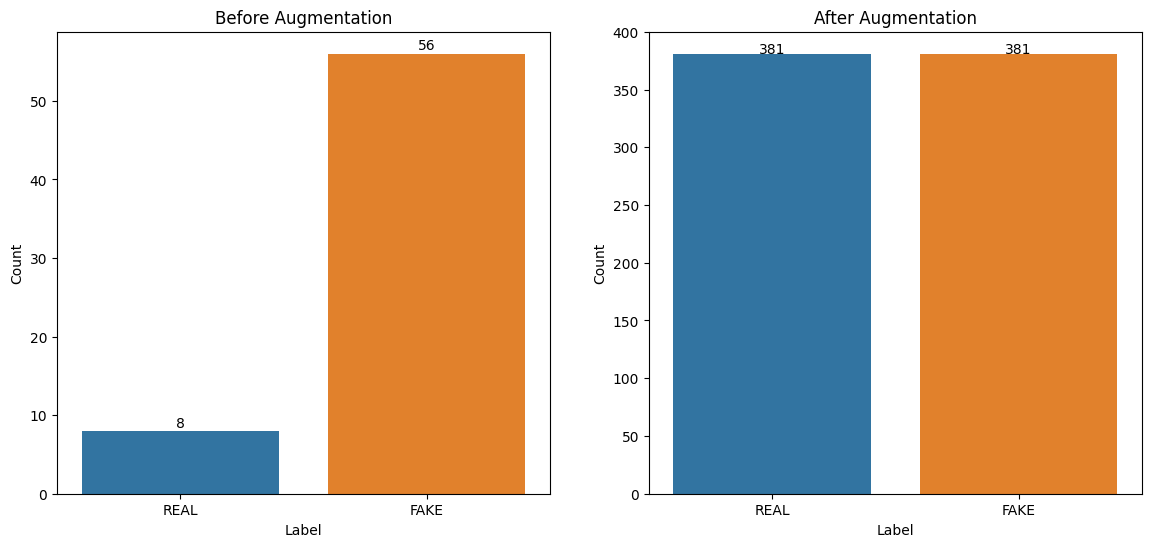

In [14]:

original_real_path = os.path.join(dataset_path, "REAL")
original_fake_path = os.path.join(dataset_path, "FAKE")
augmented_real_path = os.path.join(augmented_dataset_path, "REAL")
augmented_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")

num_original_real = len(os.listdir(original_real_path))
num_original_fake = len(os.listdir(original_fake_path))


num_augmented_real = len(os.listdir(augmented_real_path))
num_augmented_fake = len(os.listdir(augmented_fake_path))


data_pre_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_original_real, num_original_fake]}
data_post_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_augmented_real, num_augmented_fake]}


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Before Augmentation')
for i, count in enumerate(data_pre_augmentation['Count']):
    axes[0].text(i, count + 0.5, str(count), ha='center')


sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('After Augmentation')
for i, count in enumerate(data_post_augmentation['Count']):
    axes[1].text(i, count + 0.5, str(count), ha='center')

plt.show()

In [15]:

def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

fake_samples_path = "/kaggle/working/SPLITTED/SELECTED_FAKE"
real_samples_path = "/kaggle/working/SPLITTED/REAL"

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(0)


for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(1)

X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


5 rows of extracted features:
Features: [-368.5633     142.79454      3.582991    19.238045     8.022557
   13.346424     6.471809    -6.955549    -9.889773    -3.6933026
   -1.6682317   -1.0762032   -1.8560927], Label: 0
Features: [-466.50876    109.957      -25.400368    22.650402   -13.2748375
    5.432964   -19.717918   -12.340814    -6.7751865  -13.95288
   -8.192336    -5.5340624   -9.132246 ], Label: 0
Features: [-3.0052014e+02  1.5457320e+02 -3.8288818e+01 -1.2570183e+00
  2.9194573e-01  4.2607922e-02 -1.8464964e+01 -4.0784740e+00
  3.0096459e+00 -1.3112094e+01 -1.8139744e+00  6.5127838e-01
 -4.1167703e+00], Label: 0
Features: [-279.2156     118.84234    -52.878334    18.936605   -19.749285
   -3.8469872  -24.44888     -4.3997755   -3.9675944  -12.744321
   -1.7524887   -5.974425    -5.575479 ], Label: 0
Features: [-3.36919678e+02  1.53579834e+02 -2.15723667e+01  4.91579361e+01
 -1.05686694e-01  2.78822289e+01 -4.46248722e+00 -3.22976685e+00
  2.56039929e+00 -1.01837406e+01  3.

In [16]:
model_accuracy={}

# Naive Bayes

In [17]:
model = GaussianNB()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Naive Bayes"] = accuracy

Accuracy: 0.8562091503267973
Precision: 0.8970588235294118
Recall: 0.8026315789473685
F1-score: 0.8472222222222222


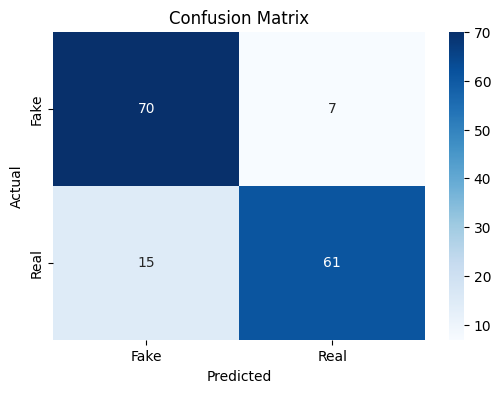

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        77
           1       0.90      0.80      0.85        76

    accuracy                           0.86       153
   macro avg       0.86      0.86      0.86       153
weighted avg       0.86      0.86      0.86       153



# K-Nearest Neighbors (KNN)



In [20]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'distance', 'selector__k': 11}
Best score: 0.9852323533396559


In [21]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [22]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.8562091503267973
Precision: 0.961038961038961
Recall: 0.9736842105263158
F1-score: 0.9673202614379085


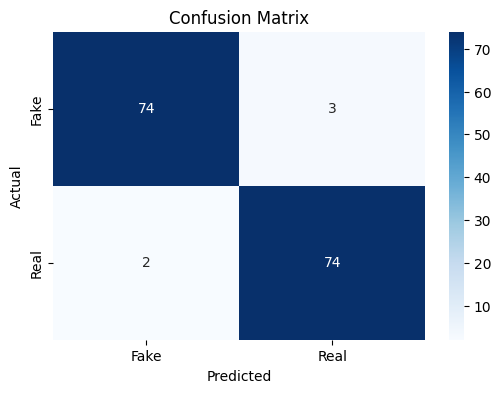

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        77
           1       0.96      0.97      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



# Support Vector Machine (SVM)

In [25]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('svm', SVC(probability=True))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'selector__k': 13, 'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best score: 0.9917897303888363


In [26]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.9803921568627451
Precision: 0.974025974025974
Recall: 0.9868421052631579
F1-score: 0.9803921568627451


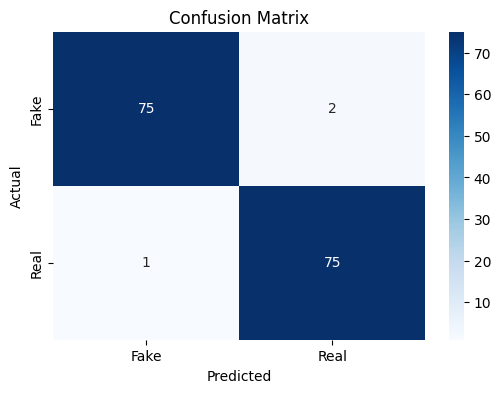

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        77
           1       0.97      0.99      0.98        76

    accuracy                           0.98       153
   macro avg       0.98      0.98      0.98       153
weighted avg       0.98      0.98      0.98       153



# Logistic Regression

In [30]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'selector__k': 13}
Best score: 0.8226663053786751


In [31]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Logistic Regression"] = accuracy

Accuracy: 0.8627450980392157
Precision: 0.8666666666666667
Recall: 0.8552631578947368
F1-score: 0.8609271523178808


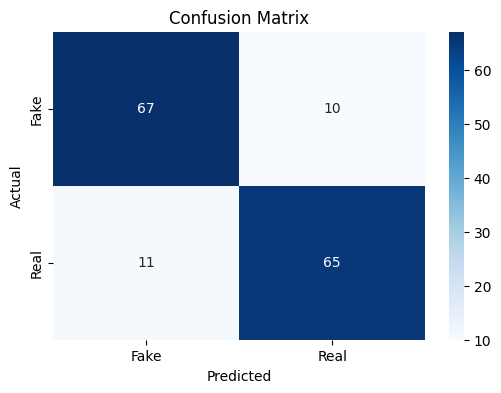

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        77
           1       0.87      0.86      0.86        76

    accuracy                           0.86       153
   macro avg       0.86      0.86      0.86       153
weighted avg       0.86      0.86      0.86       153



# Random Forest

In [34]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__bootstrap': [True, False]
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__n_estimators': 200, 'selector__k': 11}
Best score: 0.97207695434223


In [35]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Random Forest"] = accuracy

Accuracy: 0.9673202614379085
Precision: 0.9863013698630136
Recall: 0.9473684210526315
F1-score: 0.9664429530201343


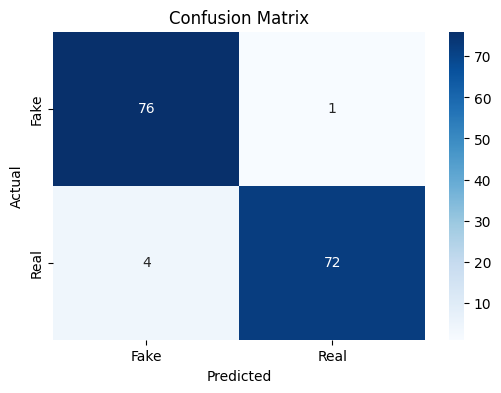

In [36]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        77
           1       0.99      0.95      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



# Decision Tree

In [38]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'selector__k': 9}
Best score: 0.9294404552228697


In [39]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Decision Tree"] = accuracy

Accuracy: 0.8954248366013072
Precision: 0.9054054054054054
Recall: 0.881578947368421
F1-score: 0.8933333333333333


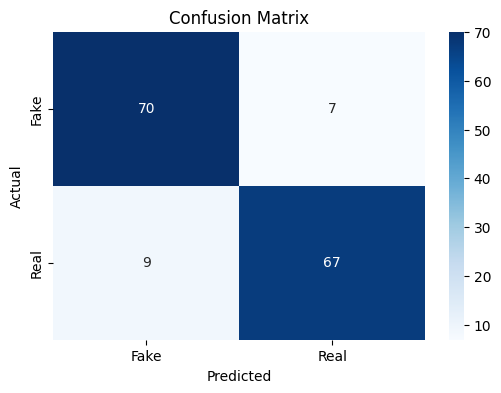

In [40]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        77
           1       0.91      0.88      0.89        76

    accuracy                           0.90       153
   macro avg       0.90      0.90      0.90       153
weighted avg       0.90      0.90      0.90       153



# CatBoost

In [42]:
catboost= CatBoostClassifier(verbose=0, random_state=42)

catboost.fit(X_train, y_train)

y_pred = catboost.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["CatBoost"] = accuracy

Accuracy: 0.9803921568627451
Precision: 0.9866666666666667
Recall: 0.9736842105263158
F1-score: 0.9801324503311258


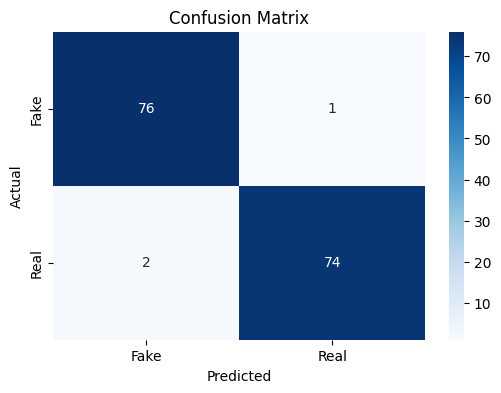

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        77
           1       0.99      0.97      0.98        76

    accuracy                           0.98       153
   macro avg       0.98      0.98      0.98       153
weighted avg       0.98      0.98      0.98       153



# eXtreme Gradient Boosting (XGB)

In [46]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["XGB"] = accuracy

Accuracy: 0.954248366013072
Precision: 0.96
Recall: 0.9473684210526315
F1-score: 0.9536423841059603


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


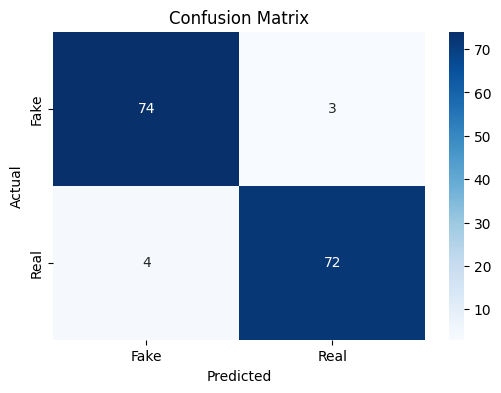

In [47]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.96      0.95      0.95        76

    accuracy                           0.95       153
   macro avg       0.95      0.95      0.95       153
weighted avg       0.95      0.95      0.95       153



# Long Short-Term Memory (LSTM)

In [56]:
from sklearn.preprocessing import StandardScaler
def extract_mfcc_sequence(file_path, n_mfcc=13, max_length=100):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = mfccs.T
    mfccs = pad_sequences([mfccs], maxlen=max_length, padding='post', truncating='post')[0]
    return mfccs

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(0)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(1)


X = np.array(features)
y = np.array(labels)

X_reshaped = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

y = to_categorical(y)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


In [72]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
model_accuracy["LSTM"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.6926 - loss: 0.6254 - val_accuracy: 0.8235 - val_loss: 0.4148
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.8156 - loss: 0.4348 - val_accuracy: 0.8758 - val_loss: 0.2953
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.8828 - loss: 0.3165 - val_accuracy: 0.9020 - val_loss: 0.2826
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.8456 - loss: 0.3306 - val_accuracy: 0.9412 - val_loss: 0.2185
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.9220 - loss: 0.2159 - val_accuracy: 0.9216 - val_loss: 0.2145
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9297 - loss: 0.1804 - val_accuracy: 0.9216 - val_loss: 0.2706
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9406 - loss: 0.1770 - val_accuracy: 0.9216 - val_loss: 0.2549
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9453 - loss: 0.1626 - val_accuracy: 

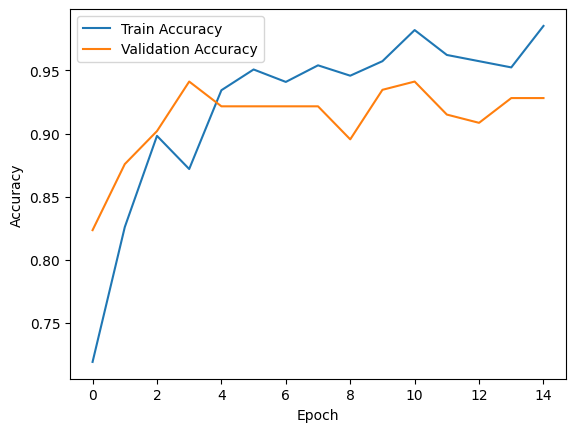

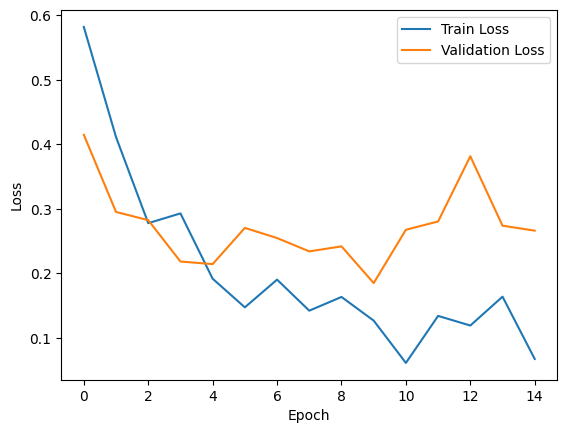

In [73]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(32))
# model.add(Dense(2, activation='softmax'))


# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")
# model_accuracy["LSTM"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.6340 - loss: 0.6406 - val_accuracy: 0.8366 - val_loss: 0.4283
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.8191 - loss: 0.4284 - val_accuracy: 0.8301 - val_loss: 0.3832
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.8474 - loss: 0.3644 - val_accuracy: 0.9216 - val_loss: 0.3354
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.8751 - loss: 0.3047 - val_accuracy: 0.8758 - val_loss: 0.2952
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.8845 - loss: 0.2312 - val_accuracy: 0.8824 - val_loss: 0.3019
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9276 - loss: 0.1831 - val_accuracy: 0.9020 - val_loss: 0.3355
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.9416 - loss: 0.2170 - val_accuracy: 0.9085 - val_loss: 0.2851
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.9291 - loss: 0.1759 - val_accuracy: 

In [75]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))
model.add(LSTM(32,kernel_regularizer=l2(0.0001)))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
model_accuracy["LSTM"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.5944 - loss: 0.6758 - val_accuracy: 0.8170 - val_loss: 0.4684
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.8311 - loss: 0.4441 - val_accuracy: 0.8105 - val_loss: 0.3846
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8211 - loss: 0.4229 - val_accuracy: 0.9150 - val_loss: 0.2606
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.8630 - loss: 0.3399 - val_accuracy: 0.9281 - val_loss: 0.2521
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.9220 - loss: 0.2226 - val_accuracy: 0.9281 - val_loss: 0.2347
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9265 - loss: 0.2447 - val_accuracy: 0.9216 - val_loss: 0.2948
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.9048 - loss: 0.2673 - val_accuracy: 0.9020 - val_loss: 0.3227
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9234 - loss: 0.2496 - val_accuracy: 

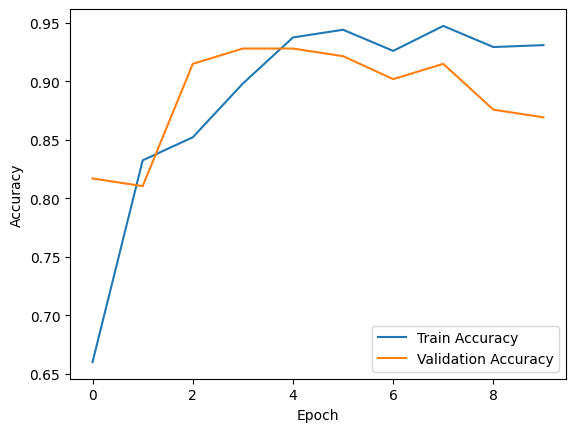

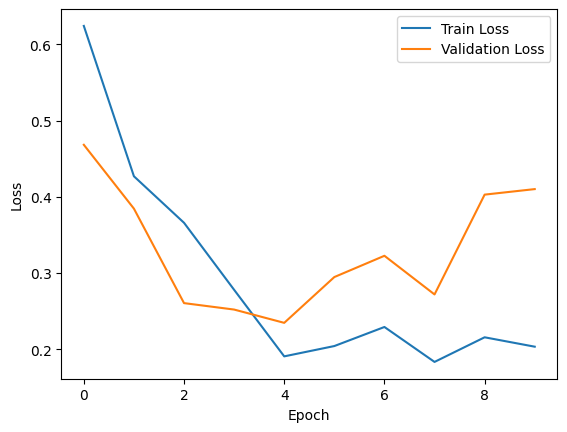

In [76]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Convolutional Neural Network (CNN)

In [79]:
def save_spectrogram(file_path, output_dir, n_mels=128, fmax=8000):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmax=fmax)
    plt.axis('off')
    output_path = os.path.join(output_dir, os.path.basename(file_path).replace('.wav', '.png'))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

fake_output_dir = "/kaggle/working/SPECTROGRAMS/FAKE"
real_output_dir = "/kaggle/working/SPECTROGRAMS/REAL"
os.makedirs(fake_output_dir, exist_ok=True)
os.makedirs(real_output_dir, exist_ok=True)

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, fake_output_dir)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, real_output_dir)


Examples of FAKE Spectrograms:


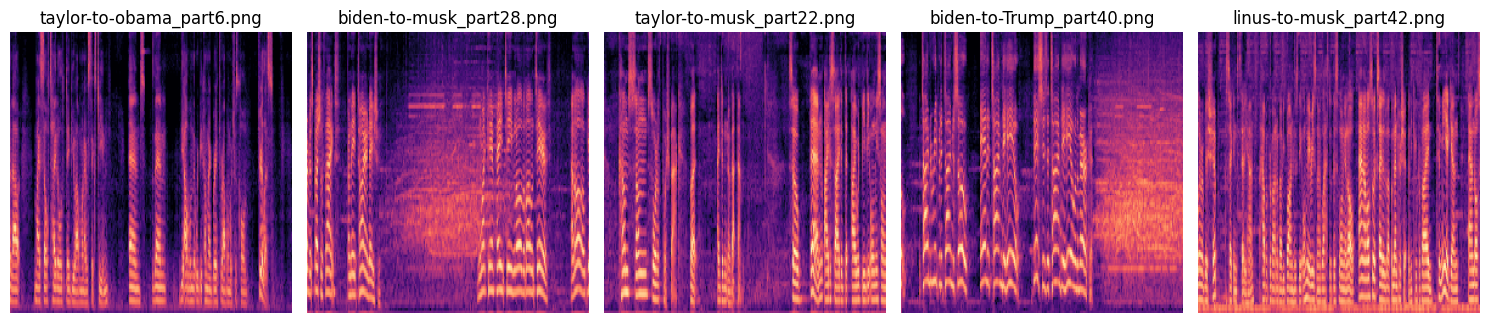


Examples of REAL Spectrograms:


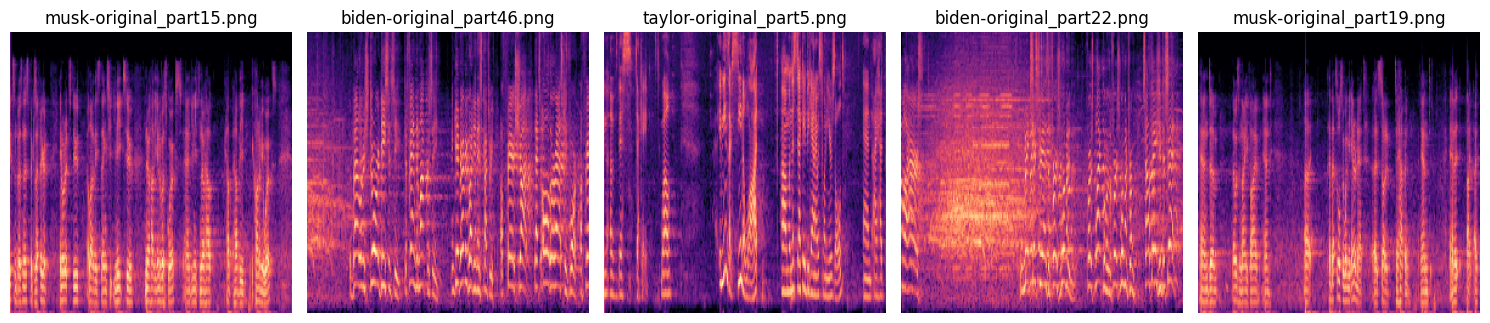

In [81]:
from PIL import Image

def display_spectrograms(directory, num_images=5):
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    if len(image_files) == 0:
        print("Nema dostupnih spektrograma u direktoriju.")
        return

    num_images = min(num_images, len(image_files))
    plt.figure(figsize=(15, 5))

    for i, file_name in enumerate(image_files[:num_images]):
        file_path = os.path.join(directory, file_name)
        img = Image.open(file_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(file_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Examples of FAKE Spectrograms:")
display_spectrograms(fake_output_dir, num_images=5)
print()
print("Examples of REAL Spectrograms:")
display_spectrograms(real_output_dir, num_images=5)

In [82]:
train_dir = "/kaggle/working/SPECTROGRAMS"
batch_size = 32
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 610 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [83]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
model_accuracy["CNN"] = accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5120 - loss: 2.0269 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5296 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5185 - loss: 0.6921 - val_accuracy: 0.7566 - val_loss: 0.6766
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6609 - loss: 0.6701 - val_accuracy: 0.8092 - val_loss: 0.6241
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7457 - loss: 0.5811 - val_accuracy: 0.7566 - val_loss: 0.5394
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7304 - loss: 0.5608 - val_accuracy: 0.7961 - val_loss: 0.5105
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7863 - loss: 0.4536 - val_accuracy: 0.8487 - val_loss: 0.3858
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8701 - loss: 0.3201 - val_accuracy: 0.8289 - val_loss: 0.4149
Epo

In [85]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
model_accuracy["CNN"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4823 - loss: 1.4908 - val_accuracy: 0.5526 - val_loss: 0.6910
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4991 - loss: 0.6912 - val_accuracy: 0.7632 - val_loss: 0.6445
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6799 - loss: 0.6056 - val_accuracy: 0.8750 - val_loss: 0.4471
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8034 - loss: 0.4714 - val_accuracy: 0.8026 - val_loss: 0.3905
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8492 - loss: 0.3442 - val_accuracy: 0.7566 - val_loss: 0.4976
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8248 - loss: 0.4247 - val_accuracy: 0.8684 - val_loss: 0.4555
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8406 - loss: 0.3901 - val_accuracy: 0.8618 - val_loss: 0.3739
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8622 - loss: 0.3287 - val_accuracy: 0.7961 - val_loss:

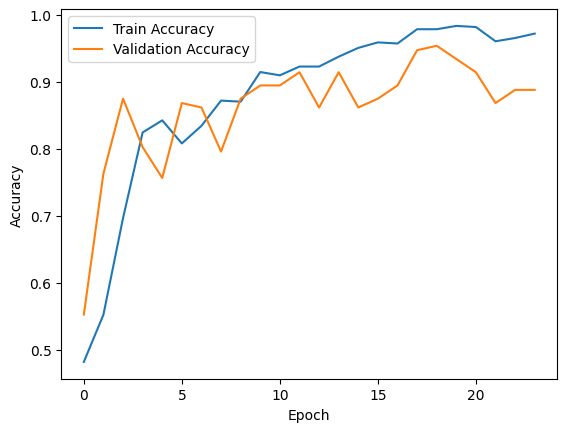

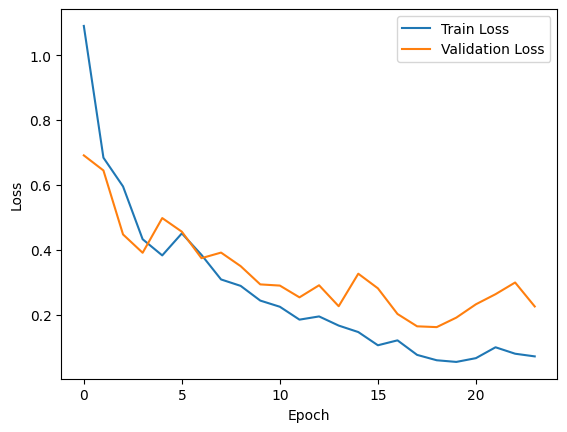

In [86]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

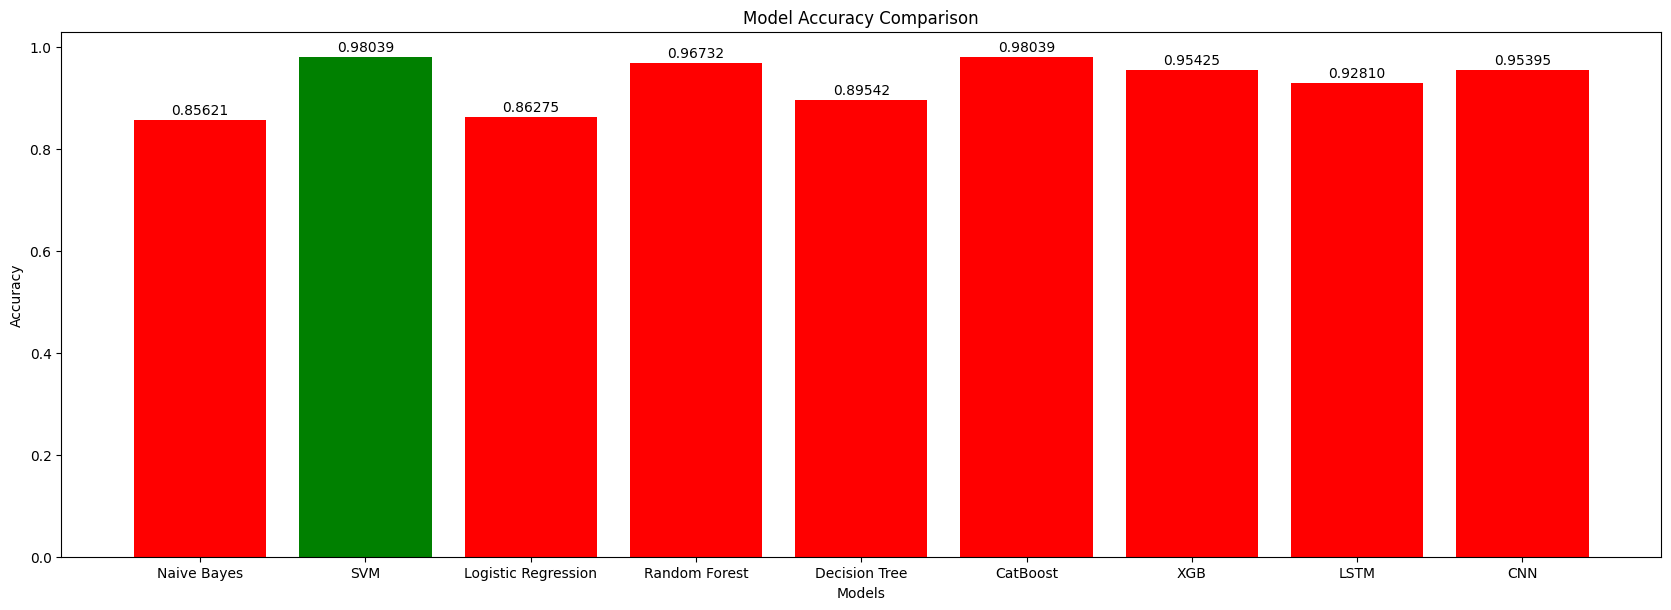

In [87]:
models = list(model_accuracy.keys())
accuracies = list(model_accuracy.values())

max_index = accuracies.index(max(accuracies))
colors = ['green' if i == max_index else 'red' for i in range(len(models))]

plt.figure(figsize=(20, 7))
plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.5f}", ha='center', va='bottom')
plt.show()